In [336]:
# Imports
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from solveFDFD import solveFDFD
%matplotlib inline

In [337]:
# Define E&M Parameters
pol = 'TM'         # polarization (TM -> Ez,Hx,Hy) (TE -> Hz,Ex,Ey)
timing = True      # whether to time FDFD steps
L0 = 1e-6          # length scale (m)
wvlen = 0.5        # wavelength (L0)
xrange = [-2, 2]   # x position boundaries (L0)
yrange = [-2, 2]   # y position boundaries (L0)
Nx = 120           # number of grid points in x
Ny = 120           # number of grid points in y
L_box = 40         # x-size of device region in grid points (centered)
H_box = 40         # y-size of device region in grid points (centered)
eps = 3.            # maximum permittivity of region
npml = 10          # number of pml points on each side

In [338]:
# Define neural network parameters
n_hidden = [5, 5] # list of hidden layer sizes
beta = 1                    # sigmoid steepness

In [339]:
N_iters = 50
learning_rate = 100.

In [340]:
# Set Up Simulation Variables
nx = int(Nx//2)                                # x halfway index
ny = int(Ny//2)                                # y halfway index
k0 = 2*np.pi/wvlen                             # free-space wavevector
src_pos_og = int((Nx/2.0-npml)//2) + npml      # original source x-position
src_pos_aj = Nx - int((Nx/2.0-npml)//2) + npml # adjoint  source y-potision
eps_r = np.ones((Nx,Ny))                       # relative permittivity grid
SRC_og = np.zeros((Nx,Ny))                     # original current source injection grid
SRC_aj = np.zeros((Nx,Ny))                     # adjoint current source injection grid
SRC_og[src_pos_og,ny] = 1                      # set original current source
SRC_aj[src_pos_aj,ny] = 1                      # set adjoint current source
Npml = [npml,npml,npml,npml]                   # set pml boundaries
delta_device = np.zeros((Nx,Ny))               # set optimization/device region
delta_device[nx-int(L_box//2):nx+int(L_box//2), ny-int(H_box//2):ny+int(H_box//2)] = 1


In [341]:
# Setup neural network variables
x = tf.placeholder("float", [2,Nx*Ny])                                    # input matrix placeholder [(x,y),#points]
y = tf.placeholder("float", [1, 1])                                       # output matrix placeholder (single value)
xpoints = np.linspace(xrange[0],xrange[1],Nx)                             # x probe positions (L0)
ypoints = np.linspace(yrange[0],yrange[1],Ny)                             # y probe positions (L0)
positions = np.array([[xp,yp] for xp in xpoints for yp in ypoints]).T     # array of (x,y) positions to feed to network
N_hidden_layers = len(n_hidden)                                           # get number of hidden layers


In [342]:
# Define and initialize weights and biases
weights = {}
biases = {}
n_prev = 2
for l in range(1,N_hidden_layers+2):
    weight_name = 'w' + str(l)
    bias_name   = 'b' + str(l)
    if l == N_hidden_layers+1:
        n_curr = 1
    else:
        n_curr = n_hidden[l-1]  
    weight_vals = tf.random_normal([n_curr,n_prev])
    bias_vals   = tf.random_normal([n_curr,1])
    weights[weight_name] = tf.Variable(weight_vals)
    biases[bias_name]    = tf.Variable(bias_vals)
    
    n_prev = n_curr    

In [343]:
# Define neural network (phi(x,y)) and gradients
def neural_net(x):
    layer_prev = tf.tanh(tf.add(tf.matmul(weights['w1'],x), biases['b1']))    
    for l in range(2,N_hidden_layers+1):
        layer_l = tf.tanh(tf.add(tf.matmul(weights['w'+str(l)],layer_prev), biases['b'+str(l)]))
        layer_prev = layer_l
    layer_end = tf.sigmoid(tf.multiply(tf.constant(beta*1.),tf.add(tf.matmul(weights['w'+str(N_hidden_layers+1)],layer_prev), biases['b'+str(N_hidden_layers+1)])))
    epsilon_unmasked = tf.add(tf.constant(1.), tf.multiply(tf.add(tf.constant(eps),tf.constant(-1.)),layer_end))
    return tf.add(tf.constant(np.reshape(1.*(delta_device==0),(1,Nx*Ny)),dtype='float32'), tf.multiply(tf.constant(np.reshape(delta_device,(1,Nx*Ny)),dtype='float32'),epsilon_unmasked))

grads = {}
for l in range(1,N_hidden_layers+2):
    weight_label = 'w' + str(l)
    bias_label = 'b' + str(l)
    grads[weight_label] = tf.gradients(neural_net(x), [weights[weight_label]])
    grads[bias_label] = tf.gradients(neural_net(x), [biases[bias_label]])

sess = tf.Session()
sess.run(tf.global_variables_initializer())

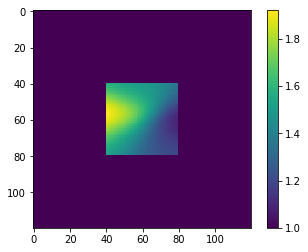

In [344]:
# Compute the phi level-set function
phis = sess.run(neural_net(x), feed_dict={x:positions})
gradients = {}
for l in range(1,N_hidden_layers+2):
    weight_label = 'w' + str(l)
    bias_label = 'b' + str(l)
    grads[weight_label] = tf.gradients(neural_net(x), [weights[weight_label]])
    grads[bias_label] = tf.gradients(neural_net(x), [biases[bias_label]])
    
#dw1s = sess.run(grads['w1'], feed_dict={x:positions})
phis = np.reshape(phis,(Nx,Ny))
plt.imshow(phis)
plt.colorbar()
plt.show()

In [345]:
# Do original simulation and adjoint simulation
(_, _, Ez_og, Hx_og, Hy_og, _, _) = solveFDFD(pol, L0, wvlen, xrange, yrange, eps_r, SRC_og, Npml, timing=timing)
(_, _, Ez_aj, Hx_aj, Hy_aj, _, _) = solveFDFD(pol, L0, wvlen, xrange, yrange, eps_r, SRC_aj, Npml, timing=timing)

setup time          : 0.000535011291504
S-parameters        : 0.00884985923767
derivative matrices : 2.06166219711
final system solving: 0.842641115189
setup time          : 0.000136852264404
S-parameters        : 0.00420904159546
derivative matrices : 1.91641712189
final system solving: 0.658952951431


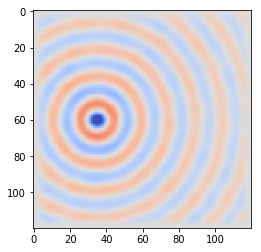

In [346]:
# Plot original fields and get field strength
imgplot_og = plt.imshow(np.real(Ez_og), clim=(-1,1))
imgplot_og.set_cmap('coolwarm')
plt.show()
meas = np.sum(Ez_og.T*SRC_aj)

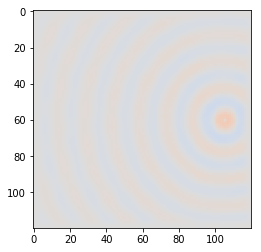

In [347]:
# Multiply the correct adjoint prefactor and plot adjoint fields
Ez_aj_norm = -2*np.multiply(np.conj(meas),Ez_aj)
imgplot_aj = plt.imshow(np.real(Ez_aj_norm), clim=(-2,2))
imgplot_aj.set_cmap('coolwarm')
plt.show()

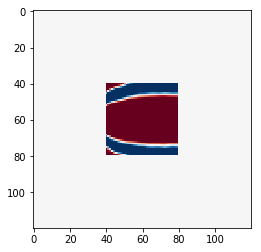

In [348]:
# Compute adjoint sensitivity and plot
dJde = -k0**2*np.real(np.multiply(np.multiply(Ez_aj_norm,Ez_og),delta_device.T))
imgplot_sens = plt.imshow(dJde,clim=(-2,2))
imgplot_sens.set_cmap('RdBu')
plt.show()

In [351]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
gradients = {}
Js = []
for i in range(N_iters):
    # get epsilon distribution
    sess.run(tf.global_variables_initializer())    
    eps_r = np.reshape(sess.run(neural_net(x), feed_dict={x:positions}),(Nx,Ny))
    # Do original simulation and adjoint simulation
    (_, _, Ez_og, Hx_og, Hy_og, _, _) = solveFDFD(pol, L0, wvlen, xrange, yrange, eps_r, SRC_og, Npml, timing=False)
    meas = np.sum(Ez_og.T*SRC_aj)  
    Js.append(np.abs(np.sum(np.sum(np.multiply(Ez_og.T,SRC_aj)))))
    print(Js[i])
    #plt.imshow(eps_r)
    #plt.show()
    (_, _, Ez_aj, Hx_aj, Hy_aj, _, _) = solveFDFD(pol, L0, wvlen, xrange, yrange, eps_r, SRC_aj, Npml, timing=False)
    Ez_aj_norm = -2.*np.multiply(np.conj(meas),Ez_aj)        
    # compute weight gradients
    sensitivity_kernel = np.reshape(np.real(np.multiply(Ez_og,Ez_aj).T),(1,Nx*Ny))
    sensitivity_kernel = np.ones((1,Nx*Ny))
    for l in range(1,N_hidden_layers+2):
        weight_label = 'w' + str(l)
        bias_label = 'b' + str(l)
        wgrad = tf.gradients(tf.multiply(neural_net(x), sensitivity_kernel), [weights[weight_label]])
        gradients[weight_label] = sess.run(wgrad, feed_dict={x:positions})
        weights[weight_label] = tf.add(weights[weight_label],tf.multiply(learning_rate,gradients[weight_label][0] ))
        bgrad = tf.gradients(tf.multiply(neural_net(x), sensitivity_kernel), [biases[bias_label]])
        gradients[bias_label]   = sess.run(bgrad, feed_dict={x:positions})
        biases[bias_label] = tf.add(biases[bias_label],tf.multiply(learning_rate,gradients[bias_label][0] ))
    
    

0.267010359315
0.267010359315


KeyboardInterrupt: 

In [ ]:
plt.plot(Js)
plt.show()

In [ ]:
plt.imshow(eps_r)